<a href="https://colab.research.google.com/github/dried021/study-repo/blob/main/%5B1014%5D_torchvision_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1-2주차: 기본 구현 (1) + 기초 이론

- 코딩 목표: 기본적인 PyTorch 구조 이해 + Custom Dataset으로 데이터 Load하기
- 이론 목표: cs231n 7강 (Training Neural Network) 까지 내용 숙지

- 내용:

  ○ MNIST와 CIFAR-10 이미지 데이터셋을 Custom Dataset을 활용하여 Load

  ○ Model은 VGG, ResNet 등 상관 없이 원하는 모델을 torchvision 라이브러리에서 불러와서 사용

  ○ Test 데이터셋에 대한 정확도 80%를 목표로 하여 모델 training or fine-tuning 진행

  ○ 기초 이론 공부를 위해 cs231n 강좌를 7강까지 수강

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim

import PIL.Image as Image
import matplotlib.pyplot as plt

import copy
import time

import numpy as np

In [ ]:
torch.__version__

'2.8.0+cu126'

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
  '''
  root_dir : 데이터를 저장할 경로
  data : 데이터 종류
  train : train data 여부
  transform : 정의하지 않을 경우 tensor 변환 후 평균 0.5 분산 1.0으로 정규화

  get_item_for_viz(idx): 시각화를 위한 역정규화
  '''

  def __init__(self, root_dir='/content', data='MNIST', train=True, transform=None):
    if transform==None:
      if data=='MNIST':
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5), std=(1.0))
        ])
      else:
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5), std=(1.0))
        ])
    else:
      self.transform = transform

    self.datasets = {
      'MNIST': torchvision.datasets.MNIST,
      'CIFAR10': torchvision.datasets.CIFAR10
    }

    torch_datasets = self.datasets.get(data)
    if torch_datasets:
      self.data=torch_datasets(
          root=root_dir,
          train=train,
          download=True,
          transform=self.transform
      )
    else:
      self.data = None

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image, label = self.data[idx]
    return image, label

  def get_item_for_viz(self, idx):
    image, label = self.data[idx]
    image = image * 1.0 + 0.5
    image = torch.clamp(image, 0, 1)
    return image, label

In [ ]:
mnist_train = CustomDataset(data='MNIST', train=True)
mnist_test = CustomDataset(data='MNIST', train=False)

cifar_train = CustomDataset(data='CIFAR10', train=True)
cifar_test = CustomDataset(data='CIFAR10', train=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.08MB/s]
100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


### Train/Val 분할 / Data 확인

In [ ]:
mnist_train_size = int(0.8*len(mnist_train))
mnist_val_size = len(mnist_train) - mnist_train_size

cifar_train_size = int(0.8*len(cifar_train))
cifar_val_size = len(cifar_train) - cifar_train_size


mnist_train_data, mnist_val_data = random_split(
    mnist_train,
    [mnist_train_size, mnist_val_size]
)

cifar_train_data, cifar_val_data = random_split(
    cifar_train,
    [cifar_train_size, cifar_val_size]
)

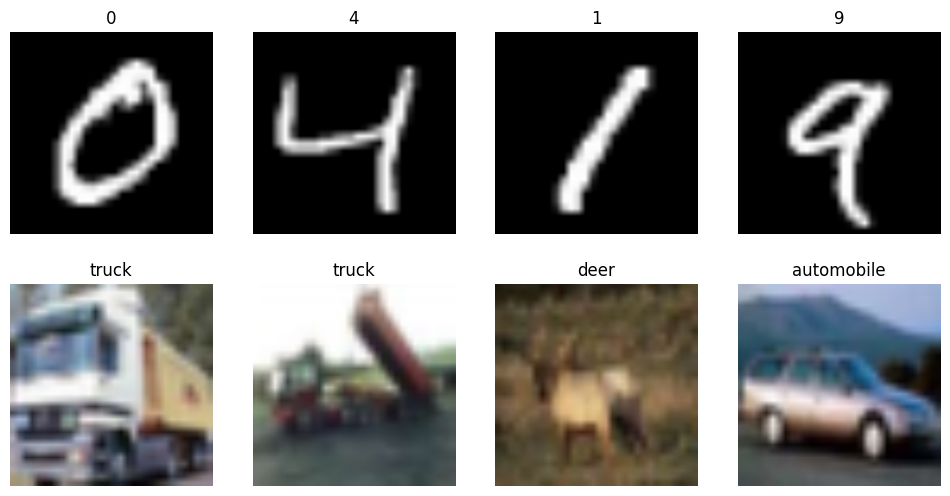

In [ ]:
cifar_labels_map={
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

figure = plt.figure(figsize=(12, 6))
for i in range(1, 5):
  image, label = mnist_train.get_item_for_viz(i)
  image=image.permute(1, 2, 0)
  figure.add_subplot(2, 4, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

for i in range(1, 5):
  image, label = cifar_train.get_item_for_viz(i)
  image=image.permute(1, 2, 0)
  figure.add_subplot(2, 4, i+4)
  label = cifar_labels_map[label]
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

plt.show()

In [ ]:
mnist_dataloaders = {
    'train': DataLoader(mnist_train_data, batch_size = 8, shuffle = True, num_workers = 2),
    'val' : DataLoader(mnist_val_data, batch_size=8, shuffle=False, num_workers=2),
    'test': DataLoader(mnist_test, batch_size=8, shuffle=False, num_workers=2),
}

cifar_dataloaders = {
    'train': DataLoader(cifar_train_data, batch_size = 8, shuffle = True, num_workers = 2),
    'val' : DataLoader(cifar_val_data, batch_size=8, shuffle=False, num_workers=2),
    'test': DataLoader(cifar_test, batch_size=8, shuffle=False, num_workers=2)
}

## Training

In [ ]:
num_classes = 10
batch_size = 8
num_epochs = 10
feature_extract = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, dataloaders, criterion, optimizer, num_epochs=25):
  since = time.time()

  val_acc_history = []
  val_loss_history = []
  train_acc_history = []
  train_loss_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*20)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        #forward
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss/len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double()/len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
      else:
          val_loss_history.append(epoch_loss)
          val_acc_history.append(epoch_acc)

          if epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model, {
        'train_acc': train_acc_history,
        'train_loss': train_loss_history,
        'val_acc': val_acc_history,
        'val_loss': val_loss_history
    }

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model, num_classes, feature_extract, use_pretrained=True):
  model_ft = None
  input_size = 0

  if model == "resnet":
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  elif model == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

  elif model == "vgg":
      model_ft = models.vgg11_bn(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier[6].in_features
      model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
      input_size = 224

  return model_ft, input_size

### AlexNet - MNIST

In [ ]:
model_name="alexnet"
mnist_alexnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [ ]:
mnist_alexnet = mnist_alexnet.to(device)

params_to_update = mnist_alexnet.parameters()
print("Params to learn:")
if feature_extract:
  params_to_update = []
  for name, param in mnist_alexnet.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t", name)
else:
  for name, param in mnist_alexnet.named_parameters():
    if param.requires_grad == True:
      print("\t", name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
mnist_alexnet, mnist_alexnet_history = train(mnist_alexnet, mnist_dataloaders, criterion,
                                            optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
--------------------
train Loss: 0.0876 Acc: 0.9733

val Loss: 0.0359 Acc: 0.9896

Epoch 1/9
--------------------
train Loss: 0.0327 Acc: 0.9897

val Loss: 0.0234 Acc: 0.9928

Epoch 2/9
--------------------
train Loss: 0.0233 Acc: 0.9930

val Loss: 0.0298 Acc: 0.9912

Epoch 3/9
--------------------
train Loss: 0.0186 Acc: 0.9942

val Loss: 0.0223 Acc: 0.9937

Epoch 4/9
--------------------
train Loss: 0.0141 Acc: 0.9958

val Loss: 0.0347 Acc: 0.9912

Epoch 5/9
--------------------
train Loss: 0.0125 Acc: 0.9963

val Loss: 0.0245 Acc: 0.9941

Epoch 6/9
--------------------
train Loss: 0.0082 Acc: 0.9978

val Loss: 0.0262 Acc: 0.9944

Epoch 7/9
--------------------
train Loss: 0.0060 Acc: 0.9983

val Loss: 0.0230 Acc: 0.9943

Epoch 8/9
--------------------
train Loss: 0.0062 Acc: 0.9982

val Loss: 0.0239 Acc: 0.9938

Epoch 9/9
--------------------
train Loss: 0.0058 Acc: 0.9981

val Loss: 0.0237 Acc: 0.9943

Training complete in 30m 2s
Best val Acc: 0.994417


### AlexNet - CIFAR10

In [ ]:
model_name="alexnet"
cifar_alexnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [ ]:
cifar_alexnet = cifar_alexnet.to(device)

params_to_update = cifar_alexnet.parameters()
print("Params to learn:")
if feature_extract:
  params_to_update = []
  for name, param in cifar_alexnet.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t", name)
else:
  for name, param in cifar_alexnet.named_parameters():
    if param.requires_grad == True:
      print("\t", name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
cifar_alexnet, cifar_alexnet_history = train(cifar_alexnet, cifar_dataloaders, criterion,
                                            optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
--------------------
train Loss: 0.7764 Acc: 0.7282

val Loss: 0.4760 Acc: 0.8314

Epoch 1/9
--------------------
train Loss: 0.4457 Acc: 0.8470

val Loss: 0.4588 Acc: 0.8444

Epoch 2/9
--------------------
train Loss: 0.3372 Acc: 0.8817

val Loss: 0.3505 Acc: 0.8762

Epoch 3/9
--------------------
train Loss: 0.2694 Acc: 0.9038

val Loss: 0.3626 Acc: 0.8768

Epoch 4/9
--------------------
train Loss: 0.2156 Acc: 0.9234

val Loss: 0.3435 Acc: 0.8853

Epoch 5/9
--------------------
train Loss: 0.1704 Acc: 0.9397

val Loss: 0.3471 Acc: 0.8817

Epoch 6/9
--------------------
train Loss: 0.1374 Acc: 0.9513

val Loss: 0.3904 Acc: 0.8761

Epoch 7/9
--------------------
train Loss: 0.1145 Acc: 0.9604

val Loss: 0.4422 Acc: 0.8684

Epoch 8/9
--------------------
train Loss: 0.0953 Acc: 0.9672

val Loss: 0.3868 Acc: 0.8949

Epoch 9/9
--------------------
train Loss: 0.0864 Acc: 0.9694

val Loss: 0.3812 Acc: 0.8946

Training complete in 24m 42s
Best val Acc: 0.894900


### 모델 저장

In [ ]:
import os

os.makedirs('./saved_models', exist_ok=True)

# 모델 저장
torch.save({
    'model_state_dict': mnist_alexnet.state_dict(),
    'history': mnist_alexnet_history,
    'epoch': num_epochs,
    'best_acc': max(mnist_alexnet_history['val_acc'])
}, './saved_models/mnist_alexnet_best.pth')

torch.save({
    'model_state_dict': cifar_alexnet.state_dict(),
    'history': cifar_alexnet_history,
    'epoch': num_epochs,
    'best_acc': max(cifar_alexnet_history['val_acc'])
}, './saved_models/cifar_alexnet_best.pth')

print(f"  - MNIST: ./saved_models/mnist_alexnet_best.pth")
print(f"  - CIFAR: ./saved_models/cifar_alexnet_best.pth")


  - MNIST: ./saved_models/mnist_alexnet_best.pth
  - CIFAR: ./saved_models/cifar_alexnet_best.pth


In [ ]:
# 새로운 모델 인스턴스 생성
mnist_model_loaded, _ = initialize_model("alexnet", num_classes, feature_extract)
mnist_model_loaded = mnist_model_loaded.to(device)

cifar_model_loaded, _ = initialize_model("alexnet", num_classes, feature_extract)
cifar_model_loaded = cifar_model_loaded.to(device)

# 체크포인트 로드
mnist_checkpoint = torch.load('./saved_models/mnist_alexnet_best.pth')
mnist_model_loaded.load_state_dict(mnist_checkpoint['model_state_dict'])

cifar_checkpoint = torch.load('./saved_models/cifar_alexnet_best.pth')
cifar_model_loaded.load_state_dict(cifar_checkpoint['model_state_dict'])

# 평가 모드로 전환
mnist_model_loaded.eval()

print(f"  - Best Accuracy: {mnist_checkpoint['best_acc']:.4f}")
print(f"  - Trained Epochs: {mnist_checkpoint['epoch']}")

print(f"  - Best Accuracy: {cifar_checkpoint['best_acc']:.4f}")
print(f"  - Trained Epochs: {cifar_checkpoint['epoch']}")

  - Best Accuracy: 0.9944
  - Trained Epochs: 10
  - Best Accuracy: 0.8949
  - Trained Epochs: 10


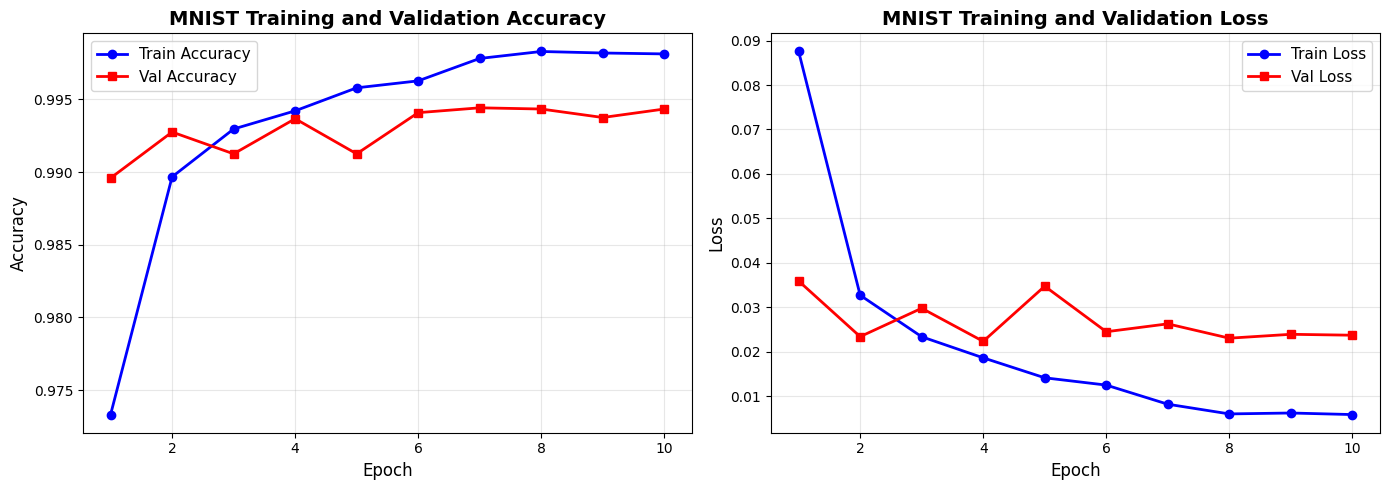

In [ ]:
ma_train_acc = [acc.cpu().item() for acc in mnist_checkpoint['history']['train_acc']]
ma_val_acc = [acc.cpu().item() for acc in mnist_checkpoint['history']['val_acc']]
ma_train_loss = mnist_checkpoint['history']['train_loss']
ma_val_loss = mnist_checkpoint['history']['val_loss']

epochs = range(1, len(ma_train_acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.plot(epochs, ma_train_acc, 'b-o', label='Train Accuracy', linewidth=2)
ax1.plot(epochs, ma_val_acc, 'r-s', label='Val Accuracy', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('MNIST Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, ma_train_loss, 'b-o', label='Train Loss', linewidth=2)
ax2.plot(epochs, ma_val_loss, 'r-s', label='Val Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('MNIST Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

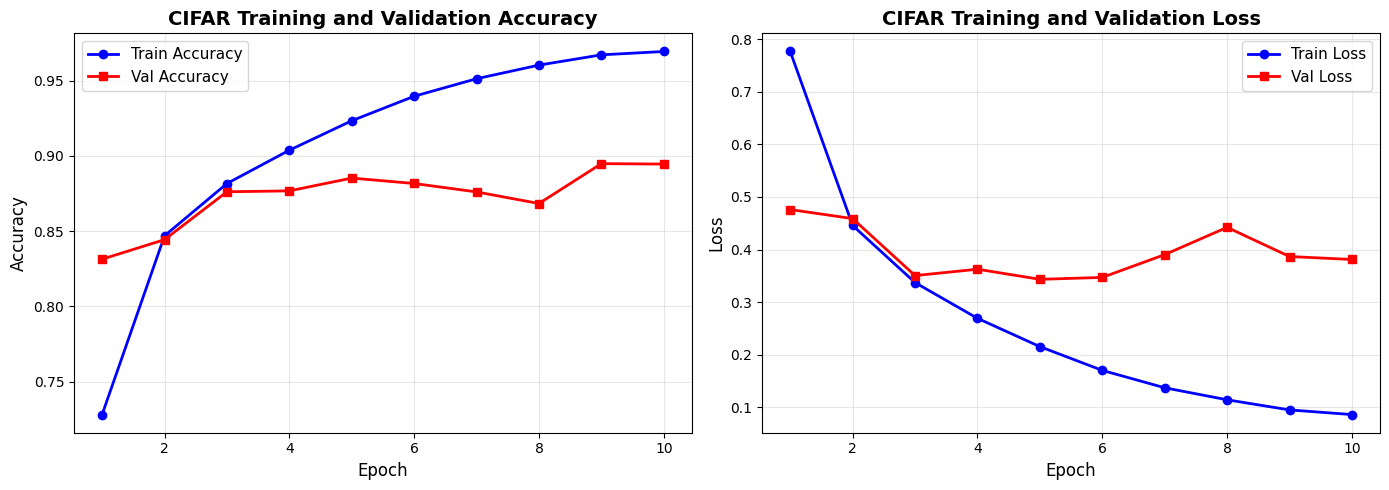

In [ ]:
ca_train_acc = [acc.cpu().item() for acc in cifar_checkpoint['history']['train_acc']]
ca_val_acc = [acc.cpu().item() for acc in cifar_checkpoint['history']['val_acc']]
ca_train_loss = cifar_checkpoint['history']['train_loss']
ca_val_loss = cifar_checkpoint['history']['val_loss']


epochs = range(1, len(ca_train_acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.plot(epochs, ca_train_acc, 'b-o', label='Train Accuracy', linewidth=2)
ax1.plot(epochs, ca_val_acc, 'r-s', label='Val Accuracy', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('CIFAR Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, ca_train_loss, 'b-o', label='Train Loss', linewidth=2)
ax2.plot(epochs, ca_val_loss, 'r-s', label='Val Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('CIFAR Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

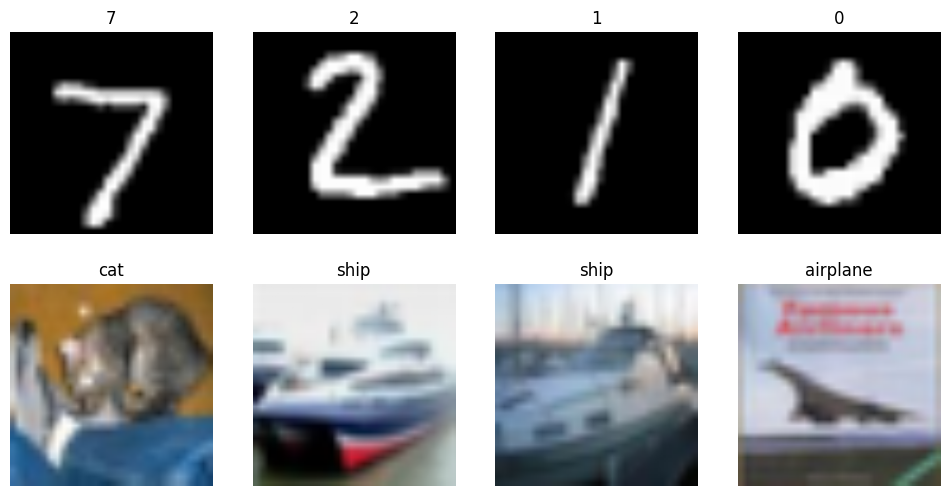

In [ ]:
import torchvision

figure = plt.figure(figsize=(12, 6))
for i in range(1, 5):
  image, label = mnist_test.get_item_for_viz(i-1)
  image=image.permute(1, 2, 0)
  figure.add_subplot(2, 4, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

for i in range(1, 5):
  image, label = cifar_test.get_item_for_viz(i-1)
  image=image.permute(1, 2, 0)
  figure.add_subplot(2, 4, i+4)
  label = cifar_labels_map[label]
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

plt.show()

In [ ]:
dataiter = iter(mnist_dataloaders['test'])
images, labels = next(dataiter)

images = images.to(device)
mnist_alexnet.eval()

output = mnist_alexnet(images)

with torch.no_grad():
    output = mnist_alexnet(images)

_, predicted = torch.max(output, 1) #dim=1
print(f"Predicted: {predicted}")
print(f"Actual: {labels}")

Predicted: tensor([7, 2, 1, 0, 4, 1, 4, 9], device='cuda:0')
Actual: tensor([7, 2, 1, 0, 4, 1, 4, 9])


In [ ]:
dataiter = iter(cifar_dataloaders['test'])
images, labels = next(dataiter)

images = images.to(device)
cifar_alexnet.eval()

output = cifar_alexnet(images)

with torch.no_grad():
    output = cifar_alexnet(images)

_, predicted = torch.max(output, 1) #dim=1

predicted_names = [cifar_labels_map[p.item()] for p in predicted]
actual_names = [cifar_labels_map[l.item()] for l in labels]

print(f"Predicted: {predicted}")
print(f"Predicted names:   {predicted_names}")

print(f"Actual: {labels}")
print(f"Predicted names:   {actual_names}")

Predicted: tensor([3, 8, 8, 0, 6, 6, 1, 6], device='cuda:0')
Predicted names:   ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']
Actual: tensor([3, 8, 8, 0, 6, 6, 1, 6])
Predicted names:   ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']


In [ ]:
def test(model, dataloaders, device):
  model.eval()

  correct = 0
  total = 0

  wrong_examples = []

  with torch.no_grad():
    for data in dataloaders['test']:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      for i in range(len(labels)):
          if len(wrong_examples) >= 5:
              break
          if predicted[i] != labels[i]:
              wrong_examples.append({
                  'image': images[i].cpu(),
                  'predicted': predicted[i].item(),
                  'actual': labels[i].item()
              })

      if len(wrong_examples) >= 5:
          break

  accuracy = 100*correct / total
  return accuracy, wrong_examples

In [ ]:
ma_accuracy, ma_wrong = test(mnist_alexnet, mnist_dataloaders, device)
ca_accuracy, ca_wrong = test(cifar_alexnet, cifar_dataloaders, device)

print(f"MNIST_ALEXNET Accuracy: {ma_accuracy:.2f}%")
print(f"CIFAR10_ALEXNET Accuracy: {ca_accuracy:.2f}%")

MNIST_ALEXNET Accuracy: 98.66%
CIFAR10_ALEXNET Accuracy: 90.62%


In [ ]:
import torchvision

figure = plt.figure(figsize=(12, 6))
for i in range(1, 5):
  image, label = mnist_test.get_item_for_viz(i-1)
  image=image.permute(1, 2, 0)
  figure.add_subplot(2, 4, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

for i in range(1, 5):
  image, label = cifar_test.get_item_for_viz(i-1)
  image=image.permute(1, 2, 0)
  figure.add_subplot(2, 4, i+4)
  label = cifar_labels_map[label]
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

plt.show()

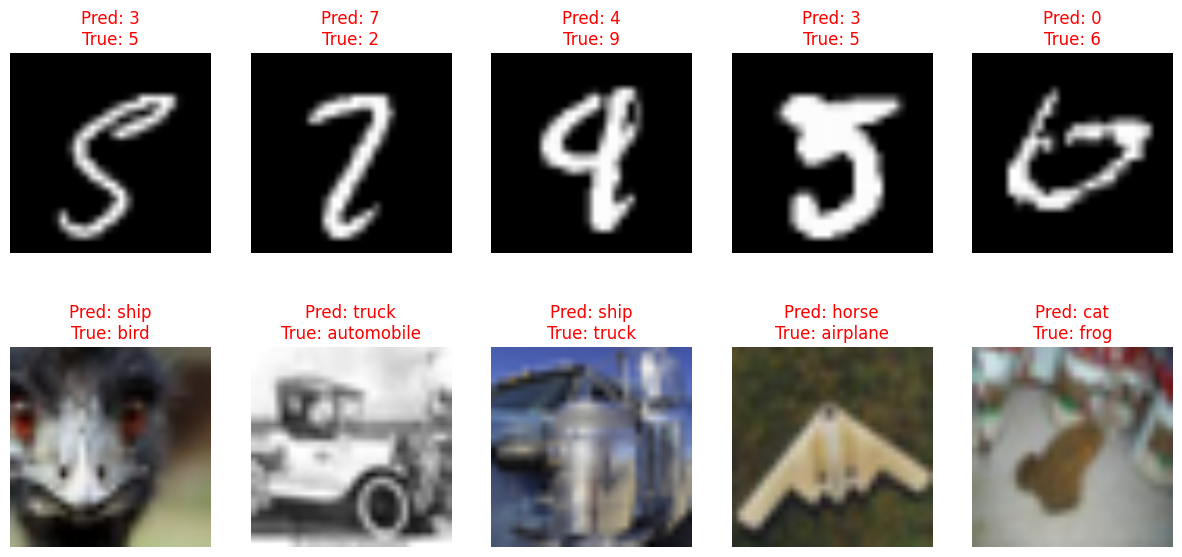

In [ ]:
figure = plt.figure(figsize=(15,7))
for i in range(1, 6):
  image = ma_wrong[i-1]['image'] * 1.0 + 0.5
  image = image.permute(1,2,0)
  figure.add_subplot(2, 5, i)
  plt.title(f"Pred: {ma_wrong[i-1]['predicted']}\nTrue: {ma_wrong[i-1]['actual']}", color='red')
  plt.axis('off')
  plt.imshow(image)

for i in range(1, 6):
  image = ca_wrong[i-1]['image'] * 1.0 + 0.5
  image = image.permute(1,2,0)
  figure.add_subplot(2, 5, i+5)
  label_predicted = cifar_labels_map[ca_wrong[i-1]['predicted']]
  label_actual =  cifar_labels_map[ca_wrong[i-1]['actual']]
  plt.title(f"Pred: {label_predicted}\nTrue: {label_actual}", color='red')
  plt.axis('off')
  plt.imshow(image)

plt.show()